# Aprendizaje supervisado: KNN

Durante este cuadernillo aprenderemos el funcionamiento de los modelos KNN. Estos modelos son los más famosos en el aprendizaje supervisado si nos centramos en la rapidez de cómputo.

Como tal, un KNN no se entrena, pues es un modelo **determinista** que _aprende_ las posiciones de los datos de entrenamiento y después intenta _colocar_ los de testeo.

Ten en cuenta que, como vamos a trabajar con aprendizaje supervisado, **SÍ** usaremos conjuntos de entrenamiento y testeo.

## Introducción teórica

El método KNN trabaja con las distancias entre los puntos de entrenamiento para intentar inducir en qué lugar del n-espacio se encuentran los puntos de testeo. A la hora de realizar esa decisión, se _pregunta_ a los k puntos más cercanos (de ahí el nombre KNN) a qué clase pertenecen y, finalmente, se asigna la clase más común al nuevo punto.

Como ya hemos ido diciendo previamente, al trabajar con distancias es muy importante tener datos **estandarizados** y con **pocas dimensiones**. Sino, el resultado del modelo puede verse muy lastrado.

Por ejemplo, en la siguiente imagen:

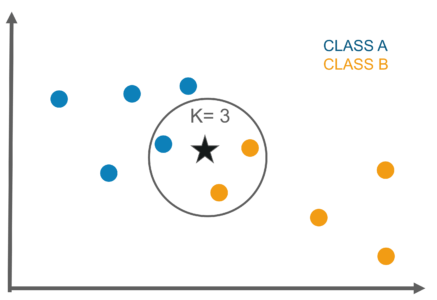

existen puntos de dos clases: azules y naranjas. Queremos introducir un nuevo punto (la estrellita), así que preguntamos a los 3 vecinos más cercanos. Como dos son de la clase naranja y uno de la clase azul, se le asignará la clase naranja al nuevo punto.

## Conjunto de datos y limpieza

Durante este cuadernillo vamos a trabajar con un conjunto de datos que nos permita realizar tareas tanto de **regresión** como de **clasificación**. Es decir: buscamos variables numéricas y categóricas.

Podemos utilizar, por ejemplo, el _dataset_ mpg sobre distintos tipos de coches.

La única variable un poco rara del conjunto de datos es ```mpg```, que mide las millas por galón consumidas.

In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
df = sns.load_dataset("mpg", cache=False)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


### Grupo de entrenamiento y testeo

En todo problema de aprendizaje supervisado, es especialmente importante separar el conjunto de datos para poder entrenar correctamente nuestros modelos.

El conjunto de testeo **NO LO TOCAREMOS** hasta el final.

In [ ]:
from sklearn.model_selection import train_test_split # elijo esta técnica, aunque podría elegir cualquiera de las vistas en 301

random_seed = 33

In [ ]:
train_val, test = train_test_split(df, test_size=0.2, random_state=random_seed)

Recuerda que usamos una semilla aleatoria para poder reproducir los resultados. En este caso, guardamos un 20% de los datos para testear.

Además, dividiremos el conjunto de entrenamiento en entrenamiento y validación, usando un 10% de los datos para validar nuestro modelo (un poco más abajo, explicaremos la importancia de hacer esto así).

In [ ]:
train, val = train_test_split(train_val, test_size=0.1, random_state=random_seed)

Al final, nuestros conjuntos tienen este tamaño.

In [ ]:
len(train), len(val), len(test)

(286, 32, 80)

### Limpieza

Al trabajar con varios conjuntos, podemos necesitar limpiar varios conjuntos de datos. Aquí hay que tener especial cuidado para no hacerse trampas a uno mismo: Los datos de validación y testeo deben modificarse de la misma forma en la que se hicieron los de entrenamiento. Por ejemplo, si creamos un objeto ```StandardScaler``` para estandarizar los datos, **NO** (y esto es **SUPER IMPORTANTE**) debemos reentrenar este escalador para los datos de validación ni testeo.

Necesitaremos estas funciones, que ya las hemos visto, para ir más rápidos.

In [ ]:
import math

def outlier_eliminator(df, threshold: float = 0.05):
  s_df = df.describe() # statistical dataframe

  for column in s_df.columns:
    # datos necesarios
    n = s_df.loc["count", column]
    q1 = s_df.loc["25%", column]
    q3 = s_df.loc["75%", column]
    mean = s_df.loc["mean", column] # 50% no es la media, es la mediana
    iqr = (q3 - q1) * 1.5

    # calculos
    _range = [mean - iqr, mean + iqr]
    outliers = df[(df[column] < _range[0]) | (df[column] > _range[1])]

    # outliers
    print(f"Outliers para la columna {column}: {len(outliers)} de {n}. BORRADOS: ", end="")
    if len(outliers) != 0 and len(outliers) / n < threshold:
      print("Sí.")
      df = df[(df[column] > _range[0]) & (df[column] < _range[1])] # fíjate que le doy la vuelta
    else:
      print("No.")

    print("### --- ###")

  return df

def categorical_variability(df, threshold: float = 0.2): # threshold > 0.33 no tiene sentido para binarias
  categorical_df = df.select_dtypes(exclude="number")
  threshold *= len(df) # obtengo el threshold absoluto

  for column in categorical_df.columns:
    serie = categorical_df[column].value_counts()
    n_categories = len(serie)
    non_variability = serie[0] - sum(serie[1:])
    if n_categories == 1 or (n_categories == 2 and non_variability > threshold * 3) or (n_categories > 2 and non_variability > threshold):
      print(f"Cuidado, la columna {column} tiene una NO variabilidad de {non_variability}, que supera el threshold establecido.")

def numerical_variability(df, threshold: float = 0.1):
  numerical_df = df.select_dtypes("number")

  for column in numerical_df.columns:
    serie = numerical_df[column].value_counts()
    _max = serie.iloc[0] # primer elemento (el más grande) ; max es una palabra reservada
    prop = _max / len(df) * 100.0 # proportion
    if prop > threshold * 100.0:
      print(f"Cuidado, la proporción de valores idénticos para la columna {column} es de {prop}%, que supera el threshold establecido.")

def binary_categorizer(dataframe, column, code_map: dict = None, cols: int = None):
  result = [] # resultados
  if not cols: # puede ser que me obliguen a que haya un número determinado de columnas
    cols = math.ceil(math.log2(len(dataframe[column].unique()))) # aplico la fórmula de log_2_n y lo aproximo al número más grande
  if not code_map:
    code_map = {value: key for key, value in enumerate(dataframe[column].unique())} # creo el mapa de forma genérica si no existe

  for value in dataframe[column]: # para cada valor
    code = code_map[value] # recojo el código asignado
    b_code = format(code, "b") # lo convierto a binario

    if len(b_code) > cols: # cols no puede ser más pequeño que el código
      raise Exception(f"El número de columnas ({cols}) es demasiado pequeño para empaquetar la información ({len(b_code)}). Modifica el valor del atributo cols.")

    b_code_a = b_code.rjust(cols, "0") # lo formateo hasta tamaño cols rellenando con 0
    _value = list(b_code_a) # lo convierto a lista: cada elemento en una posición diferente 00 -> ["0", "0"]
    result.append(list(map(lambda v: int(v), _value))) # convierto la lista en una lista de enteros ["0", "0"] -> [0, 0]

  new_columns_name = [f"{column}_{i}" for i in range(len(list(result[0])))] # les daré nombre a las nuevas columnas
  result_df = pd.DataFrame(result, index=dataframe.index, columns=new_columns_name) # creo un nuevo df con los resultados
  dataframe = pd.concat([dataframe, result_df], axis=1) # lo añado en el eje X respetando el orden
  return dataframe.drop(columns=[column]), code_map

Antes de nada, voy a analizar la correlación para no tener columnas que al final acabe eliminando.

In [ ]:
train.corr(numeric_only=True) # fíjate, con el conjunto de entrenamiento

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
mpg,1.000000,-0.778513,-0.804889,-0.778874,-0.829119,0.393903,0.566159
cylinders,-0.778513,1.000000,0.950925,0.852237,0.891336,-0.532466,-0.323074
displacement,-0.804889,0.950925,1.000000,0.898691,0.927749,-0.559627,-0.337167
horsepower,-0.778874,0.852237,0.898691,1.000000,0.863938,-0.676805,-0.388890
weight,-0.829119,0.891336,0.927749,0.863938,1.000000,-0.412277,-0.276797
acceleration,0.393903,-0.532466,-0.559627,-0.676805,-0.412277,1.000000,0.240974
model_year,0.566159,-0.323074,-0.337167,-0.388890,-0.276797,0.240974,1.000000


Voy a borrar las columnas ```displacement``` (correlada con todas excepto ```acceleration``` y ```model_year```) y ```horsepower``` (relacionada con ```cylinders``` y ```weight```) y ```weight``` (relacionada con ```mpg```).

In [ ]:
train = train.drop(columns=["displacement", "horsepower", "weight"])

# estos cambios sí involucran a los demás conjuntos
train_val = train_val.drop(columns=["displacement", "horsepower", "weight"])
val = val.drop(columns=["displacement", "horsepower", "weight"])
test = test.drop(columns=["displacement", "horsepower", "weight"])

Como querremos aplicar la misma limpieza a todos los conjuntos, lo haremos con una función general de limpieza:

In [ ]:
from sklearn.impute import SimpleImputer

def data_cleaner(
    df, # el dataframe que queremos limpiar
    other = None, # otro dataframe que tenga que limpiarse de la misma forma
):
  # en general
  is_other = isinstance(other, pd.DataFrame) # necesito saber si tengo un other

  # columnas inútiles, valores sin sentido y atípicos
  ## columnas inútiles
  ### no me interesa la columna "name"
  df = df.drop(columns="name")
  if is_other: other = other.drop(columns="name")

  ## valores sin sentido
  ### NO los hay (llamada a .describe() para comprobarlo)

  ## valores atípicos
  df = outlier_eliminator(df)
  ### el otro (validación o testeo) NO se toca aquí

  # datos nulos
  ## NO tenemos ninguno, ¿qué pasaría si tuviésemos alguno en val y test? PROBLEMAS
  ## aunque no tengamos ninguno aquí, tenemos que prevenirnos por si los tuviésemos
  ## en el resto (y mirarlo es trampa, porque podría suceder en inferencia -- con
  ## nuevos datos--).
  if is_other:
    # separo mis datos para aplicar distintas estrategias
    _df = df.select_dtypes(include="number") ; __df = df.select_dtypes(exclude="number")

    # creo dos imputadores
    numeric_si = SimpleImputer() ; categorical_si = SimpleImputer(strategy="most_frequent")

    # los entreno con el conjunto de ENTRENAMIENTO
    numeric_si = numeric_si.fit(_df) ; categorical_si = categorical_si.fit(__df)

    # obtengo los resultados
    df = pd.concat([
        pd.DataFrame(numeric_si.transform(_df), columns=_df.columns),
        pd.DataFrame(categorical_si.transform(__df), columns=__df.columns)],
        axis=1) # en el eje X

    # y para el otro conjunto
    _other = other.select_dtypes(include="number") ; __other = other.select_dtypes(exclude="number")
    other = pd.concat([
        pd.DataFrame(numeric_si.transform(_other), columns=_other.columns),
        pd.DataFrame(categorical_si.transform(__other), columns=__other.columns)],
        axis=1) # en el eje X

  # variabilidad
  categorical_variability(df)
  numerical_variability(df)

  # codificación de variables categóricas
  ## lo dejo para después

  return df, other

Vamos a ver un ejemplo de qué obtenemos al final.

In [ ]:
data_cleaner(train)[0]

Outliers para la columna mpg: 5 de 286.0. BORRADOS: Sí.
### --- ###
Outliers para la columna cylinders: 0 de 286.0. BORRADOS: No.
### --- ###
Outliers para la columna acceleration: 15 de 286.0. BORRADOS: No.
### --- ###
Outliers para la columna model_year: 0 de 286.0. BORRADOS: No.
### --- ###
Cuidado, la columna origin tiene una NO variabilidad de 71, que supera el threshold establecido.
Cuidado, la proporción de valores idénticos para la columna cylinders es de 52.313167259786475%, que supera el threshold establecido.
Cuidado, la proporción de valores idénticos para la columna model_year es de 11.032028469750891%, que supera el threshold establecido.


/tmp/ipython-input-1792276722.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  non_variability = serie[0] - sum(serie[1:])


,mpg,cylinders,acceleration,model_year,origin
18,27.0,4,14.5,70,japan
132,25.0,4,17.0,74,usa
106,12.0,8,12.5,73,usa
16,18.0,6,15.5,70,usa
369,34.0,4,18.0,82,usa
...,...,...,...,...,...
129,31.0,4,19.0,74,japan
118,24.0,4,15.5,73,europe
126,21.0,6,17.0,74,usa
222,17.0,8,19.0,77,usa


## Ejemplo de clasificador KNN

Recuerda: durante este cuadernillo vamos a ver los dos tipos de uso del KNN (**regresión** y **clasificación**). Vamos a comenzar con la clasificación.

El objetivo de este ejemplo es clasificar cada uno de los coches intentando predecir su origen. En este sentido, nuestra variable ```origin``` es el ```target```, así que vamos a separar nuestro conjunto de entrenamiento.

Además, vamos a necesitar importar el modelo y una métrica que nos permita analizar cómo de bien funciona. En este caso, como es un problema de **clasificación**, usaremos la **precisión**.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

Limpiamos nuestro conjunto de datos y de validación.

In [ ]:
_train, _val = data_cleaner(train, val)

Outliers para la columna mpg: 5 de 286.0. BORRADOS: Sí.
### --- ###
Outliers para la columna cylinders: 0 de 286.0. BORRADOS: No.
### --- ###
Outliers para la columna acceleration: 15 de 286.0. BORRADOS: No.
### --- ###
Outliers para la columna model_year: 0 de 286.0. BORRADOS: No.
### --- ###
Cuidado, la columna origin tiene una NO variabilidad de 71, que supera el threshold establecido.
Cuidado, la proporción de valores idénticos para la columna cylinders es de 52.313167259786475%, que supera el threshold establecido.
Cuidado, la proporción de valores idénticos para la columna model_year es de 11.032028469750891%, que supera el threshold establecido.


/tmp/ipython-input-1792276722.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  non_variability = serie[0] - sum(serie[1:])


En este caso, la columna ```origin``` es nuestra variable a predecir (no la vamos a eliminar) y las variables ```cylinders``` y ```model_year``` parecen fundamentales para el análisis, así que las mantenemos aunque puedan tener problemas de variabilidad.

Ahora, separamos la columna que nos interesa.

In [ ]:
X_train, y_train = _train.drop(columns="origin"), _train.origin
X_val, y_val = _val.drop(columns="origin"), _val.origin

Vamos a ver qué obtenemos si **NO** estandarizamos nuestros datos.

In [ ]:
model = KNeighborsClassifier()
model = model.fit(X_train, y_train) # entrenamos con el entrenamiento
pred = model.predict(X_train) # obtenemos la predicción para el entrenamiento
pred[:10] # esto es un ejemplo de lo que obtenemos

array(['japan', 'europe', 'usa', 'usa', 'japan', 'europe', 'europe',
       'usa', 'japan', 'europe'], dtype=object)

Vamos a ver qué metrica obtenemos para el entrenamiento.

In [ ]:
accuracy_score(y_train, pred)

0.7615658362989324

Como puedes ver, el proceso es bastante generalizable, así que vamos a crear una función que, dados dos conjuntos, un modelo y una métrica, realice todas las operaciones por nosotros.

In [ ]:
def evaluate(X_train, y_train, X_test, y_test, model, metric):
  # entrenamiento
  model = model.fit(X_train, y_train)

  # métrica de entrenamiento
  train_score = metric(y_train, model.predict(X_train))

  # métrica de testeo
  test_score = metric(y_test, model.predict(X_test))

  return model, train_score, test_score

In [ ]:
model, train_score, val_score = evaluate(X_train, y_train, X_val, y_val, KNeighborsClassifier(), accuracy_score)
train_score, val_score

(0.7615658362989324, 0.6875)

Vemos que funciona (y que en la validación tenemos algo menos de precisión --esto es lo más normal del mundo--).

Vamos a ver qué pasa si estandarizamos nuestros datos. Vamos a aprovechar que ya tenemos el conjunto de datos separado de la columna objetivo, estandaricemos nuestros datos _X_.

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss = ss.fit(X_train) # solo entrenamiento

# ahora transformo
X_train_std = ss.transform(X_train)
X_val_std = ss.transform(X_val)

X_train_std

array([[ 0.50289286, -0.83726212, -0.42481451, -1.55859421],
       [ 0.2354321 , -0.83726212,  0.49741106, -0.4811896 ],
       [-1.50306284,  1.53322308, -1.16259497, -0.75054075],
       ...,
       [-0.29948942,  0.34798048,  0.49741106, -0.4811896 ],
       [-0.83441094,  1.53322308,  1.23519152,  0.32686385],
       [-1.50306284,  1.53322308, -1.71593031, -0.75054075]])

In [ ]:
model, train_score, val_score = evaluate(X_train_std, y_train, X_val_std, y_val, KNeighborsClassifier(), accuracy_score)
train_score, val_score

(0.7722419928825622, 0.625)

Mejora el entrenamiento, pero empeora la validación.

### Profundización

A la hora de entrenar un modelo KNN, podemos modificar los siguientes parámetros:
- ```n_neighbors```: número de vecinos consultados para incluir un nuevo punto.
- ```weights```: valores ```uniform``` o ```distance```. Si se establece a ```distance```, los vecinos más cercanos tienen más importancia en caso de empates.
- ```algorithm```: el algoritmo utilizado para calcular los vecinos. ```auto```, ```ball_tree```, ```kd_tree``` y ```brute```. Por defecto ```auto```.
- ```p```: la potencia de la métrica (recuerda: ```p=1``` es Manhattan; ```p=2``` es Euclídea).
- ```metric```: la métrica utilizada. Por defecto se usa la de ```minkowski```. Puedes usar las que ya hemos visto, como ```cosine``` y otras.

En general, para optimizar este algoritmo solo se modifica la cantidad de vecinos (tú puedes modificar otros si quieres).

In [ ]:
best_val_model = []

for k in range(3, 20, 2): # me preocupo de coger siempre una cantidad impar
  model, train_score, val_score = evaluate(X_train_std, y_train, X_val_std, y_val, KNeighborsClassifier(k), accuracy_score)
  metric_importance = train_score * 0.2 + val_score * 0.8 # hago una media ponderada. Me interesa más un buen resultado en validación
  if not best_val_model or metric_importance > best_val_model[-1]: # problema de maximización
    print(f"Se ha encontrado un nuevo mejor modelo con {k} vecinos. Entrenamiento {train_score} - Validación {val_score}")
    best_val_model = [model, train_score, val_score, metric_importance]

Se ha encontrado un nuevo mejor modelo con 3 vecinos. Entrenamiento 0.8078291814946619 - Validación 0.6875
Se ha encontrado un nuevo mejor modelo con 7 vecinos. Entrenamiento 0.7793594306049823 - Validación 0.71875


Parece que nuestro modelo con 7 vecinos es el mejor que podemos obtener.

Antes de probar el resultado final, vamos a reducir el número de dimensiones. Aunque solo tengamos 4, recuerda que estos modelos son especialmente vulnerables a la **maldición de la dimensionalidad**. Quizá así podemos mejorar nuestros resultados.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
best_val_model = []

for n in range(1, 5): # vamos a incluir la extracción de información en la optimización del modelo
  for k in range(3, 20, 2): # me preocupo de coger siempre una cantidad impar
    pca = PCA(n_components=n).fit(X_train_std)
    X_train_pca = pca.transform(X_train_std)
    X_val_pca = pca.transform(X_val_std)

    model, train_score, val_score = evaluate(X_train_pca, y_train, X_val_pca, y_val, KNeighborsClassifier(k), accuracy_score)

    metric_importance = train_score * 0.2 + val_score * 0.8
    if not best_val_model or metric_importance > best_val_model[-1]: # problema de maximización
      print(f"Se ha encontrado un nuevo mejor modelo con {k} vecinos en {n} dimensiones. Entrenamiento {train_score} - Validación {val_score}")
      best_val_model = [model, train_score, val_score, metric_importance]

Se ha encontrado un nuevo mejor modelo con 3 vecinos en 1 dimensiones. Entrenamiento 0.7686832740213523 - Validación 0.46875
Se ha encontrado un nuevo mejor modelo con 5 vecinos en 1 dimensiones. Entrenamiento 0.7117437722419929 - Validación 0.53125
Se ha encontrado un nuevo mejor modelo con 7 vecinos en 1 dimensiones. Entrenamiento 0.6868327402135231 - Validación 0.5625
Se ha encontrado un nuevo mejor modelo con 9 vecinos en 1 dimensiones. Entrenamiento 0.6832740213523132 - Validación 0.625
Se ha encontrado un nuevo mejor modelo con 15 vecinos en 1 dimensiones. Entrenamiento 0.6583629893238434 - Validación 0.71875
Se ha encontrado un nuevo mejor modelo con 9 vecinos en 2 dimensiones. Entrenamiento 0.6832740213523132 - Validación 0.71875
Se ha encontrado un nuevo mejor modelo con 11 vecinos en 2 dimensiones. Entrenamiento 0.693950177935943 - Validación 0.71875
Se ha encontrado un nuevo mejor modelo con 13 vecinos en 2 dimensiones. Entrenamiento 0.6903914590747331 - Validación 0.78125


Obtenemos un mejor modelo al usar 13 vecinos con 2 dimensiones.

Ha llegado el momento de **testear**.

Recuperamos el conjunto combinado train_val para compararlo contra test. Tenemos que aplicar todos los cambios realizados hasta ahora (limpieza + estandarización + reducción de la dimensionalidad).

In [ ]:
# limpieza
_train_val, _test = data_cleaner(train_val, test)

# separacion de conjunto y objetivo
X_train_val, y_train_val = _train_val.drop(columns="origin"), _train_val["origin"]
X_test, y_test = _test.drop(columns="origin"), _test["origin"]

# estandarizacion
ss = StandardScaler().fit(X_train_val)
X_train_val_std = ss.transform(X_train_val)
X_test_std = ss.transform(X_test)

# reducción de la dimensionalidad
pca = PCA(n_components=2).fit(X_train_val_std)
X_train_val_pca = pca.transform(X_train_val_std)
X_test_pca = pca.transform(X_test_std)

Outliers para la columna mpg: 7 de 318.0. BORRADOS: Sí.
### --- ###
Outliers para la columna cylinders: 0 de 318.0. BORRADOS: No.
### --- ###
Outliers para la columna acceleration: 19 de 318.0. BORRADOS: No.
### --- ###
Outliers para la columna model_year: 0 de 318.0. BORRADOS: No.
### --- ###
Cuidado, la columna origin tiene una NO variabilidad de 85, que supera el threshold establecido.
Cuidado, la proporción de valores idénticos para la columna cylinders es de 51.446945337620576%, que supera el threshold establecido.
Cuidado, la proporción de valores idénticos para la columna model_year es de 10.610932475884244%, que supera el threshold establecido.


/tmp/ipython-input-1792276722.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  non_variability = serie[0] - sum(serie[1:])


Entrenamos nuestro **modelo final**.

In [ ]:
model = KNeighborsClassifier(13) # la mejor K obtenida

# obtenemos los resultados
model, train_score, test_score = evaluate(X_train_val_pca, y_train_val, X_test_pca, y_test, model, accuracy_score)

Y estos son nuestros resultados finales **(inmutables)**:

In [ ]:
train_score, test_score

(0.7009646302250804, 0.65)

## Ejemplo de regresor KNN

Durante el ejemplo anterior hemos visto cómo podemos utilizar un modelo KNN para crear un clasificador. Ahora, veremos cómo podemos crear un regresor.

La principal diferencia entre uno y otro es que mientras que el clasificador genera etiquetas de una categoría, el regresor genera valores de una regresión (que son infinitos).

Todas las ideas vistas para el clasificador nos sirven para el regresor. La única diferencia es que tenemos que codificar nuestra variable ```origin```, que ahora forma parte del conjunto de entrenamiento.

Además, tendremos que tener especial cuidado a la hora de estandarizar nuestros datos, dado que la variable objetivo **NO DEBE** tocarse.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

Obtengamos nuestros nuevos conjuntos para entrenar, validar y testear. Recordamos sus nombres.

In [ ]:
len(train), len(val), len(test)

(286, 32, 80)

Vamos a modificar la función de limpieza para que (ahora sí) codifique la variable categórica.

In [ ]:
from sklearn.impute import SimpleImputer

def data_cleaner(
    df, # el dataframe que queremos limpiar
    other = None, # otro dataframe que tenga que limpiarse de la misma forma
):
  # en general
  is_other = isinstance(other, pd.DataFrame) # necesito saber si tengo un other

  # columnas inútiles, valores sin sentido y atípicos
  ## columnas inútiles
  ### no me interesa la columna "name"
  df = df.drop(columns="name")
  if is_other: other = other.drop(columns="name")

  ## valores sin sentido
  ### NO los hay (llamada a .describe() para comprobarlo)

  ## valores atípicos
  df = outlier_eliminator(df)
  ### el otro (validación o testeo) NO se toca aquí

  ## datos nulos
  ### NO tenemos ninguno, ¿qué pasaría si tuviésemos alguno en val y test? PROBLEMAS
  ### aunque no tengamos ninguno aquí, tenemos que prevenirnos por si los tuviésemos
  ### en el resto (y mirarlo es trampa, porque podría suceder en inferencia -- con
  ### nuevos datos--).
  if is_other:
    # separo mis datos para aplicar distintas estrategias
    _df = df.select_dtypes(include="number") ; __df = df.select_dtypes(exclude="number")

    # creo dos imputadores
    numeric_si = SimpleImputer() ; categorical_si = SimpleImputer(strategy="most_frequent")

    # los entreno con el conjunto de ENTRENAMIENTO
    numeric_si = numeric_si.fit(_df) ; categorical_si = categorical_si.fit(__df)

    # obtengo los resultados
    df = pd.concat([
        pd.DataFrame(numeric_si.transform(_df), columns=_df.columns),
        pd.DataFrame(categorical_si.transform(__df), columns=__df.columns)],
        axis=1) # en el eje X

    # y para el otro conjunto
    _other = other.select_dtypes(include="number") ; __other = other.select_dtypes(exclude="number")
    other = pd.concat([
        pd.DataFrame(numeric_si.transform(_other), columns=_other.columns),
        pd.DataFrame(categorical_si.transform(__other), columns=__other.columns)],
        axis=1) # en el eje X

  ## variabilidad
  categorical_variability(df)
  numerical_variability(df)

  ## codificación de variables categóricas
  df, code_map = binary_categorizer(df, "origin") # son 3 valores
  other, _ = binary_categorizer(other, "origin", code_map=code_map) # necesito esto porque aquí podría haber más

  return df, other

In [ ]:
train, val = data_cleaner(train, val)
train.head() # ejemplo

Outliers para la columna mpg: 5 de 286.0. BORRADOS: Sí.
### --- ###
Outliers para la columna cylinders: 0 de 286.0. BORRADOS: No.
### --- ###
Outliers para la columna acceleration: 15 de 286.0. BORRADOS: No.
### --- ###
Outliers para la columna model_year: 0 de 286.0. BORRADOS: No.
### --- ###
Cuidado, la columna origin tiene una NO variabilidad de 71, que supera el threshold establecido.
Cuidado, la proporción de valores idénticos para la columna cylinders es de 52.313167259786475%, que supera el threshold establecido.
Cuidado, la proporción de valores idénticos para la columna model_year es de 11.032028469750891%, que supera el threshold establecido.


/tmp/ipython-input-1792276722.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  non_variability = serie[0] - sum(serie[1:])


,mpg,cylinders,acceleration,model_year,origin_0,origin_1
0,27.0,4.0,14.5,70.0,0,0
1,25.0,4.0,17.0,74.0,0,1
2,12.0,8.0,12.5,73.0,0,1
3,18.0,6.0,15.5,70.0,0,1
4,34.0,4.0,18.0,82.0,0,1


Separamos, ahora, nuestra variable objetivo.

In [ ]:
X_train, y_train = train.drop(columns="mpg"), train.mpg
X_val, y_val = val.drop(columns="mpg"), val.mpg

Finalmente, entrenemos nuestro modelo base. Como el problema es ahora un problema de regresión, necesitamos utilizar una métrica distinta para comprobar nuestros resultados.

Al igual que con el caso de la clasificación, existen muchas métricas que nos permiten obtener los resultados en una regresión. Las dos más famosas son el MAE y el RMSE (esta la usaremos para la entrega del tema). Usaremos el RMSE.

In [ ]:
from sklearn.metrics import mean_squared_error # cuidado: esta segunda es el MSE, no RMSE

Definimos el RMSE.

In [ ]:
def RMSE(y_true, y_pred):
  return mean_squared_error(y_true, y_pred) ** 0.5 # raiz cuadrada

Ahora sí, entrenamos nuestro modelo.

In [ ]:
model = KNeighborsRegressor() # se optimiza de la misma forma

In [ ]:
model, train_score, val_score = evaluate(X_train, y_train, X_val, y_val, model, RMSE)
train_score, val_score

(3.0295961230895356, 4.819989626544854)

La métrica RMSE es una métrica de minimización. El objetivo es que llegue a 0.

Cualquier métrica de minimización puede convertirse en una métrica de maximización (y _viceversa_) calculando su negativo. Por ejemplo, la métrica -RMSE es una métrica de maximización.

Como antes nos ha venido bien estandarizar nuestros datos, vamos a hacer lo mismo aquí.

In [ ]:
ss = StandardScaler().fit(X_train)
X_train_std = ss.transform(X_train)
X_val_std = ss.transform(X_val)

In [ ]:
model, train_score, val_score = evaluate(X_train_std, y_train, X_val_std, y_val, KNeighborsRegressor(), RMSE)
train_score, val_score

(2.9555224863397314, 4.260014671336238)

Nuestra puntuación de entrenamiento mejora, pero **NO** la de validación. Esto es un indicador de sobreajuste. Aún así, vamos a tolerarlo y vamos a buscar el mejor número de vecinos.

In [ ]:
best_val_model = []

for k in range(3, 20, 2): # me preocupo de coger siempre una cantidad impar
  model, train_score, val_score = evaluate(X_train_std, y_train, X_val_std, y_val, KNeighborsRegressor(k), RMSE)
  metric_importance = -(train_score * 0.2 + val_score * 0.8) # hago una media ponderada. Me interesa más un buen resultado en validación
  if not best_val_model or metric_importance > best_val_model[-1]: # problema de maximización inversa
    print(f"Se ha encontrado un nuevo mejor modelo con {k} vecinos. Entrenamiento {train_score} - Validación {val_score}")
    best_val_model = [model, train_score, val_score, metric_importance]

Se ha encontrado un nuevo mejor modelo con 3 vecinos. Entrenamiento 2.5639977805033793 - Validación 4.559788006768151
Se ha encontrado un nuevo mejor modelo con 5 vecinos. Entrenamiento 2.9555224863397314 - Validación 4.260014671336238


Hagamos la misma prueba con las dimensiones.

In [ ]:
best_val_model = []

for n in range(1, 5): # vamos a incluir la extracción de información en la optimización del modelo
  for k in range(3, 20, 2): # me preocupo de coger siempre una cantidad impar
    pca = PCA(n_components=n).fit(X_train_std)
    X_train_pca = pca.transform(X_train_std)
    X_val_pca = pca.transform(X_val_std)

    model, train_score, val_score = evaluate(X_train_pca, y_train, X_val_pca, y_val, KNeighborsRegressor(k), RMSE)

    metric_importance = -val_score # probemos a usar solo los datos de validación
    if not best_val_model or metric_importance > best_val_model[-1]: # problema de maximización inversa
      print(f"Se ha encontrado un nuevo mejor modelo con {k} vecinos en {n} dimensiones. Entrenamiento {train_score} - Validación {val_score}")
      best_val_model = [model, train_score, val_score, metric_importance]

Se ha encontrado un nuevo mejor modelo con 3 vecinos en 1 dimensiones. Entrenamiento 3.870632910790036 - Validación 5.450888689012095
Se ha encontrado un nuevo mejor modelo con 9 vecinos en 1 dimensiones. Entrenamiento 4.298751457352163 - Validación 5.348610209469326
Se ha encontrado un nuevo mejor modelo con 11 vecinos en 1 dimensiones. Entrenamiento 4.277736726245966 - Validación 5.280213875817926
Se ha encontrado un nuevo mejor modelo con 13 vecinos en 1 dimensiones. Entrenamiento 4.404855049238409 - Validación 5.17572494422036
Se ha encontrado un nuevo mejor modelo con 15 vecinos en 1 dimensiones. Entrenamiento 4.422531708661482 - Validación 5.029508756661363
Se ha encontrado un nuevo mejor modelo con 17 vecinos en 1 dimensiones. Entrenamiento 4.494978337300914 - Validación 4.9687383435479475
Se ha encontrado un nuevo mejor modelo con 5 vecinos en 2 dimensiones. Entrenamiento 3.4413162672508832 - Validación 4.667408274406687
Se ha encontrado un nuevo mejor modelo con 9 vecinos en 2

Vamos a aumentar el número de vecinos, dado que hemos llegado a un máximo.

In [ ]:
best_val_model = []

for n in range(1, 5): # vamos a incluir la extracción de información en la optimización del modelo
  for k in range(3, 100, 2): # me preocupo de coger siempre una cantidad impar
    pca = PCA(n_components=n).fit(X_train_std)
    X_train_pca = pca.transform(X_train_std)
    X_val_pca = pca.transform(X_val_std)

    model, train_score, val_score = evaluate(X_train_pca, y_train, X_val_pca, y_val, KNeighborsRegressor(k), RMSE)

    metric_importance = -val_score # probemos a usar solo los datos de validación
    if not best_val_model or metric_importance > best_val_model[-1]: # problema de maximización inversa
      print(f"Se ha encontrado un nuevo mejor modelo con {k} vecinos en {n} dimensiones. Entrenamiento {train_score} - Validación {val_score}")
      best_val_model = [model, train_score, val_score, metric_importance]

Se ha encontrado un nuevo mejor modelo con 3 vecinos en 1 dimensiones. Entrenamiento 3.870632910790036 - Validación 5.450888689012095
Se ha encontrado un nuevo mejor modelo con 9 vecinos en 1 dimensiones. Entrenamiento 4.298751457352163 - Validación 5.348610209469326
Se ha encontrado un nuevo mejor modelo con 11 vecinos en 1 dimensiones. Entrenamiento 4.277736726245966 - Validación 5.280213875817926
Se ha encontrado un nuevo mejor modelo con 13 vecinos en 1 dimensiones. Entrenamiento 4.404855049238409 - Validación 5.17572494422036
Se ha encontrado un nuevo mejor modelo con 15 vecinos en 1 dimensiones. Entrenamiento 4.422531708661482 - Validación 5.029508756661363
Se ha encontrado un nuevo mejor modelo con 17 vecinos en 1 dimensiones. Entrenamiento 4.494978337300914 - Validación 4.9687383435479475
Se ha encontrado un nuevo mejor modelo con 21 vecinos en 1 dimensiones. Entrenamiento 4.607131233381156 - Validación 4.9504088335255325
Se ha encontrado un nuevo mejor modelo con 23 vecinos en

A veces sucede que los últimos resultados dan una validación muy similar. En estos casos, se suele elije el que tenga una mejor (cuidado, palabro _incoming_) [**parsimonia**](https://dle.rae.es/parsimonia).

Esto es: el modelo más simple. En este caso, el que menos vecinos utilice.

En nuestro caso, parece que el mejor es el de 45 vecinos y 2 dimensiones.
Veamos nuestros resultados finales.

In [ ]:
# limpieza
_train_val, _test = data_cleaner(train_val, test)

# separacion de conjunto y objetivo
X_train_val, y_train_val = _train_val.drop(columns="mpg"), _train_val["mpg"]
X_test, y_test = _test.drop(columns="mpg"), _test["mpg"]

# estandarizacion
ss = StandardScaler().fit(X_train_val)
X_train_val_std = ss.transform(X_train_val)
X_test_std = ss.transform(X_test)

# dimensionalidad
pca = PCA(n_components=2).fit(X_train_val_std)
X_train_val_pca = pca.transform(X_train_val_std)
X_test_pca = pca.transform(X_test_std)

Outliers para la columna mpg: 7 de 318.0. BORRADOS: Sí.
### --- ###
Outliers para la columna cylinders: 0 de 318.0. BORRADOS: No.
### --- ###
Outliers para la columna acceleration: 19 de 318.0. BORRADOS: No.
### --- ###
Outliers para la columna model_year: 0 de 318.0. BORRADOS: No.
### --- ###
Cuidado, la columna origin tiene una NO variabilidad de 85, que supera el threshold establecido.
Cuidado, la proporción de valores idénticos para la columna cylinders es de 51.446945337620576%, que supera el threshold establecido.
Cuidado, la proporción de valores idénticos para la columna model_year es de 10.610932475884244%, que supera el threshold establecido.


/tmp/ipython-input-1792276722.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  non_variability = serie[0] - sum(serie[1:])


In [ ]:
model, train_score, val_score = evaluate(X_train_val_pca, y_train_val, X_test_pca, y_test, KNeighborsRegressor(45), RMSE)
train_score, val_score

(4.095222989752149, 4.333669196385865)

En este caso, nuestros datos de testeo han empeorado el resultado (lo cuál es normal), en 2 puntos sobre el de entrenamiento.

# Resumen

Durante este cuadernillo hemos aprendido a trabajar con modelos KNN, tanto en problemas de clasificación como en problemas de regresión. Hemos visto casos prácticos de la separación en conjuntos y sobre dos métricas muy utilizadas en regresión y en clasificación.

Durante el resto de cuadernillos de aprendizaje supervisado no veremos ejemplos tan detallados, sino que nos centraremos en la optimización de estos modelos.